## preliminary defs


In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, os, json

from classifiers.squeezenet3 import SqueezeNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Part 2 - train model using pre-computed Features

### If necessary, reset tensorflow graph
Note: this will remove from memory any models that have been loaded!!!

In [2]:
tf.reset_default_graph()
sess = get_session()

### read from file
Function definition

In [3]:
def dataset_from_TFRecord ( layer_name_and_shape_list=[ ("squeezed_layer_8",13,13,64) ],   
                                filename="XandY.tfrec" ):  #, debugN=None ):
    
    Ykeys = ["angle_vert", "angle_horiz", "rooty", "rootx", "endy", "endx"]
    features1 = { name : tf.FixedLenFeature(shape=[np.prod((W,H,D))], dtype=tf.float32)  \
                for (name,W,H,D) in layer_name_and_shape_list }
    features2 = { k : tf.FixedLenFeature(shape=[1], dtype=tf.float32)  \
                for k in Ykeys }       
    features = { **features1, **features2 } # merge two dicts (python 3)
    #
    dataset = tf.data.TFRecordDataset(filename)
    #
    def input_parser(example_proto):
        # implicitly use features as defined above
        parsed_features = tf.parse_single_example(example_proto, features) 
        #reshape:
        for (name,W,H,D) in layer_name_and_shape_list :
            parsed_features[name] = tf.reshape(parsed_features[name], (W,H,D))
        return parsed_features
    #
    dataset = dataset.map(input_parser)    
    #
    return dataset


In [4]:
def dataset_XY_from_TFRecord ( layer_name_and_shape_list=[ ("squeezed_layer_8",13,13,64) ],   
                                filename="XandY.tfrec" ):  #, debugN=None ):
    
    Ykeys = ["angle_vert", "angle_horiz", "rooty", "rootx", "endy", "endx"]
    features1 = { name : tf.FixedLenFeature(shape=[np.prod((W,H,D))], dtype=tf.float32)  \
                for (name,W,H,D) in layer_name_and_shape_list }
    features2 = { k : tf.FixedLenFeature(shape=[1], dtype=tf.float32)  \
                for k in Ykeys }       
    features = { **features1, **features2 } # merge two dicts (python 3)
    #
    dataset = tf.data.TFRecordDataset(filename)
    #
    def input_parser(example_proto):
        # implicitly use features as defined above
        parsed_features = tf.parse_single_example(example_proto, features) 
        result={}
        #reshape:
        for (name,W,H,D) in layer_name_and_shape_list :
            result[name] = tf.reshape(parsed_features[name], (W,H,D))
        result['Y'] = tf.reshape(tf.stack([ parsed_features[name] for name in Ykeys ]),(6,))
        return result
    #
    dataset = dataset.map(input_parser)    
    #
    return dataset


In [5]:
def dataset_XYclassif_from_TFRecord ( layer_name_and_shape_list=[ ("squeezed_layer_8",13,13,64) ],   
                                filename="XandY.tfrec" ):  #, debugN=None ):
    
    Ykeys = ["angle_vert", "angle_horiz", "rooty", "rootx", "endy", "endx"]
    features1 = { name : tf.FixedLenFeature(shape=[np.prod((W,H,D))], dtype=tf.float32)  \
                for (name,W,H,D) in layer_name_and_shape_list }
    features2 = { k : tf.FixedLenFeature(shape=[1], dtype=tf.float32)  \
                for k in Ykeys }       
    features = { **features1, **features2 } # merge two dicts (python 3)
    #
    dataset = tf.data.TFRecordDataset(filename)
    #
    def input_parser(example_proto):
        # implicitly use features as defined above
        parsed_features = tf.parse_single_example(example_proto, features) 
        parsed_features["angle_vert"] = tf.reshape(parsed_features["angle_vert"],[])
        parsed_features["angle_horiz"] = tf.reshape(parsed_features["angle_horiz"],[])
        result={}
        #reshape:
        for (name,W,H,D) in layer_name_and_shape_list :
            result[name] = tf.reshape(parsed_features[name], (W,H,D))
        #angle_vert changes from -0.1 (down) to 0.05(horiz) to 0.2 (up)
        result['class_vert'] = tf.case( { tf.less(  parsed_features["angle_vert"], -0.02): (lambda: tf.constant(0)),
                                          tf.greater(parsed_features["angle_vert"], 0.10): (lambda: tf.constant(1))
                                        }, default = (lambda: tf.constant(2))  
                                      )
                                         
        #angle_horiz changes from -0.3 to 0.3
        result['class_horiz'] = tf.case( { tf.less( parsed_features["angle_horiz"], -0.1): (lambda: tf.constant(0)),
                                          tf.greater(parsed_features["angle_horiz"], 0.1): (lambda: tf.constant(1))
                                        }, default = (lambda: tf.constant(2))  
                                      )
                                         
        #result['Y'] = tf.reshape(tf.stack([ parsed_features[name] for name in Ykeys ]),(6,))
        
        return result
    #
    dataset = dataset.map(input_parser)    
    #
    return dataset


## new models

In [6]:
def initialize_model(var_list, sess):
    ops = [ i.initializer for i in var_list ]
    sess.run(ops)

In [14]:
handles={}

exec up to here each time

### v1: Fully connected, from layer B

#### Functions returning tensors that define the model

dont exec

In [40]:
# what is the total number of weights used?
WN=( (64+1)*18, (18+1)*18, (18+1)*6, (13*13*6+1)*6 )
print(WN, np.sum(WN))

(1170, 342, 114, 6090) 7716


In [8]:

def appended_model_v1(XB, reuse=True):
    '''input: XB - input from layer B of squeezenet
    returns: layers[0...6]'''
    x=XB
    layers=[]
    var_list=[] # list of variable tensors so that we can initialize variables for a particular model
    with tf.variable_scope('my_v1', reuse=reuse):
        with tf.variable_scope('layer0'):
            W = tf.get_variable("weights",shape=[1,1,64,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 1:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        # fully connected branch:
        #
        with tf.variable_scope('layer2'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 3:
            x = tf.nn.relu(x)
            layers.append(x)
        with tf.variable_scope('layer4'):
            W = tf.get_variable("weights",shape=[1,1,18,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 5:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        #fully connected layer:
        with tf.variable_scope('layer6'):
            W = tf.get_variable("weights",shape=[13,13,6,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,13,13,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
    return layers, var_list
                
                
def appended_full_model_v1(filename="XandY1.tfrec", batch_size=2, reuse=True):
    '''dictionary involving both X and Y.
    Expected keys: 
    X: "squeezed_layer_8" (should be obtained by taking layer B (i.e. sq.l.7) of Squeeznet that was fed in the images)
    Y: "angle_vert", "angle_horiz", "rooty", "rootx", "endy", "endx"
     '''
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[  ("squeezed_layer_8",13,13,64)  ], filename=filename )
    dsbatched=ds.repeat().batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    layers, var_list = appended_model_v1( nextdict['squeezed_layer_8'], reuse )
    y=tf.reshape(layers[6],[-1,6])
    loss = tf.losses.mean_squared_error( nextdict['Y'], y )
    return y, nextdict['Y'], loss, var_list


In [9]:
def appended_full_model_v1b(filename="XandY1.tfrec", batch_size=2, reuse=True):
    #no coordinates
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[  ("squeezed_layer_8",13,13,64)  ], filename=filename )
    dsbatched=ds.repeat().batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    layers, var_list = appended_model_v1( nextdict['squeezed_layer_8'], reuse )
    y=tf.reshape(layers[6],[-1,6])
    
    weights=tf.constant([10.,10,0,0,0,0])
    weighted_loss = tf.losses.mean_squared_error( nextdict['Y']*weights, y*weights )
    
    return y, nextdict['Y'], weighted_loss, var_list


In [10]:
def appended_full_model_v1a(filename="XandY1.tfrec", batch_size=2, reuse=True):
    
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[  ("squeezed_layer_8",13,13,64)  ], filename=filename )
    dsbatched=ds.repeat().batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    layers, var_list = appended_model_v1( nextdict['squeezed_layer_8'], reuse )
    y=tf.reshape(layers[6],[-1,6])
    
    weights=tf.constant([10.,10,1,1,1,1])
    weighted_loss = tf.losses.mean_squared_error( nextdict['Y']*weights, y*weights )
    
    return y, nextdict['Y'], weighted_loss, var_list


In [11]:
def appended_full_model_v1c(filename="XandY1.tfrec", batch_size=2, reuse=True):
    #shuffle
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[  ("squeezed_layer_8",13,13,64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    layers, var_list = appended_model_v1( nextdict['squeezed_layer_8'], reuse )
    y=tf.reshape(layers[6],[-1,6])
    
    weights=tf.constant([1.,1,0,0,0,0])
    weighted_loss = tf.losses.mean_squared_error( nextdict['Y']*weights, y*weights )
    
    return y, nextdict['Y'], weighted_loss, var_list


### v1: 4 OUTPUTS

###### v1a-try1 is run on a data set of ~4600

In [32]:
with tf.variable_scope("v1a-try1"):
    my_y3, correct_y3, my_loss3, var_list3 = appended_full_model_v1a(filename="XandY_9.tfrec", batch_size=1024, reuse=True )
    op3 = tf.train.AdamOptimizer(name="a3b",learning_rate=0.01)
    train_op3=op3.minimize(my_loss3)
    loss_history3=[]
    initialize_model(var_list3, sess)
    sess.run(tf.variables_initializer(op3.variables()))


ValueError: Variable v1a-try1/my_v1/layer0/weights does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=tf.AUTO_REUSE in VarScope?

In [ ]:
#with tf.device("/gpu:0"):
with tf.variable_scope("v1a-try1"):
    for i in range(500):
        if i%10==0:
            print ("batch ",i)
        _, loss_value = sess.run([train_op3, my_loss3])
        loss_history3.append(loss_value)
    

In [ ]:
plt.plot(loss_history3[300:500])

###### v1a-try2 is run on 4600 and has 0s for coordinates

In [ ]:
with tf.variable_scope("v1a-try2"):
    my_y4, correct_y4, my_loss4, var_list4 = appended_full_model_v1a(filename="XandY_9.tfrec", batch_size=1024, reuse=False )
    op4 = tf.train.AdamOptimizer(name="a4b",learning_rate=0.01)
    train_op4=op4.minimize(my_loss4)
    loss_history4=[]
    initialize_model(var_list4, sess)
    sess.run(tf.variables_initializer(op4.variables()))


In [ ]:
with tf.device("/gpu:0"):
    with tf.variable_scope("v1a-try2"):
        for i in range(500):
            if i%10==0:
                print ("batch ",i)
            _, loss_value = sess.run([train_op4, my_loss4])
            loss_history4.append(loss_value)

In [ ]:
plt.plot(loss_history4[300:])

###### v1a-try5 running 4600 with corrected labels

In [ ]:
with tf.variable_scope("v1a-try5"):
    my_y5, correct_y5, my_loss5, var_list5 = appended_full_model_v1a(filename="XandY_9c.tfrec", batch_size=2048, reuse=True )
    op5 = tf.train.AdamOptimizer(name="a5c",learning_rate=0.001,beta1=0.95)
    train_op5=op5.minimize(my_loss5)
    loss_history5=[]
    initialize_model(var_list5, sess)
    sess.run(tf.variables_initializer(op5.variables()))


In [ ]:
with tf.variable_scope("v1a-try5"):
    for i in range(500):
        if i%10==0:
            print ("batch ",i)
        _, loss_value = sess.run([train_op5, my_loss5])
        loss_history5.append(loss_value)
    

In [ ]:
plt.plot(loss_history5[1980:])

###### v1a=try6 is actually v1b, typo. corrected labels seems to have solved the issue

In [ ]:
with tf.variable_scope("v1a-try6"):
    my_y6, correct_y6, my_loss6, var_list6 = appended_full_model_v1b(filename="XandY_9c.tfrec", batch_size=2048, reuse=False )
    op6 = tf.train.AdamOptimizer(name="a6b",learning_rate=0.001,beta1=0.95)
    train_op6=op6.minimize(my_loss6)
    loss_history6=[]
    initialize_model(var_list6, sess)
    sess.run(tf.variables_initializer(op6.variables()))


In [ ]:
with tf.variable_scope("v1a-try6"):
    for i in range(500):
        if i%10==0:
            print ("batch ",i)
        _, loss_value = sess.run([train_op6, my_loss6])
        loss_history6.append(loss_value)

In [ ]:
plt.plot(loss_history6[1000:])

###### v1a-try7 now using shuffle(v1c)

In [ ]:
with tf.variable_scope("v1a-try7"):
    my_y7, correct_y7, my_loss7, var_list7 = appended_full_model_v1c(filename="XandY_9c.tfrec", batch_size=2048, reuse=True )
    op7 = tf.train.AdamOptimizer(name="a7b",learning_rate=0.003,beta1=0.95)
    train_op7=op7.minimize(my_loss7)
    loss_history7=[]
    initialize_model(var_list7, sess)
    sess.run(tf.variables_initializer(op7.variables()))


In [ ]:
with tf.variable_scope("v1a-try7"):
    for i in range(1000):
        if i%10==0:
            print ("batch ",i)
        _, loss_value = sess.run([train_op7, my_loss7])
        loss_history7.append(loss_value)

In [33]:
plt.plot(loss_history7[:1000])
plt.ylim(0,.025)

NameError: name 'loss_history7' is not defined

###### continue training, change learning rate on optimizer for v1a tr7

In [80]:
with tf.variable_scope("v1a-try7"):
    op7b = tf.train.AdamOptimizer(name="a7c",learning_rate=0.03,beta1=0.95)
    train_op7b=op7b.minimize(my_loss7)
    sess.run(tf.variables_initializer(op7b.variables()))


In [81]:
with tf.variable_scope("v1a-try7"):
    for i in range(1000):
        if i%10==0:
            print ("batch ",i)
        _, loss_value = sess.run([train_op7b, my_loss7])
        loss_history7.append(loss_value)

batch  0
batch  10
batch  20
batch  30
batch  40
batch  50
batch  60
batch  70
batch  80
batch  90
batch  100
batch  110
batch  120
batch  130
batch  140
batch  150
batch  160
batch  170
batch  180
batch  190
batch  200
batch  210
batch  220
batch  230
batch  240
batch  250
batch  260
batch  270
batch  280
batch  290
batch  300
batch  310
batch  320
batch  330
batch  340
batch  350
batch  360
batch  370
batch  380
batch  390
batch  400
batch  410
batch  420
batch  430
batch  440
batch  450
batch  460
batch  470
batch  480
batch  490
batch  500
batch  510
batch  520
batch  530
batch  540
batch  550
batch  560
batch  570
batch  580
batch  590
batch  600
batch  610
batch  620
batch  630
batch  640
batch  650
batch  660
batch  670
batch  680
batch  690
batch  700
batch  710
batch  720
batch  730
batch  740
batch  750
batch  760
batch  770
batch  780
batch  790
batch  800
batch  810
batch  820
batch  830
batch  840
batch  850
batch  860
batch  870
batch  880
batch  890
batch  900
batch  910

###### v1a-try8 now using shuffle(v1c)

In [94]:
with tf.variable_scope("v1a-try8"):
    my_y8, correct_y8, my_loss8, var_list8 = appended_full_model_v1c(filename="XandY_9c.tfrec", batch_size=2048, reuse=False )
    op8 = tf.train.AdamOptimizer(name="a8b",learning_rate=0.003,beta1=0.95)
    train_op8=op8.minimize(my_loss8)
    loss_history8=[]
    initialize_model(var_list8, sess)
    sess.run(tf.variables_initializer(op8.variables()))


In [95]:
with tf.variable_scope("v1a-try8"):
    for i in range(1000):
        if i%10==0:
            print ("batch ",i)
        _, loss_value = sess.run([train_op8, my_loss8])
        loss_history8.append(loss_value)

batch  0
batch  10
batch  20
batch  30
batch  40
batch  50
batch  60
batch  70
batch  80
batch  90
batch  100
batch  110
batch  120
batch  130
batch  140
batch  150
batch  160
batch  170
batch  180
batch  190
batch  200
batch  210
batch  220
batch  230
batch  240
batch  250
batch  260
batch  270
batch  280
batch  290
batch  300
batch  310
batch  320
batch  330
batch  340
batch  350
batch  360
batch  370
batch  380
batch  390
batch  400
batch  410
batch  420
batch  430
batch  440
batch  450
batch  460
batch  470
batch  480
batch  490
batch  500
batch  510
batch  520
batch  530
batch  540
batch  550
batch  560
batch  570
batch  580
batch  590
batch  600
batch  610
batch  620
batch  630
batch  640
batch  650
batch  660
batch  670
batch  680
batch  690
batch  700
batch  710
batch  720
batch  730
batch  740
batch  750
batch  760
batch  770
batch  780
batch  790
batch  800
batch  810
batch  820
batch  830
batch  840
batch  850
batch  860
batch  870
batch  880
batch  890
batch  900
batch  910

(0, 0.025)

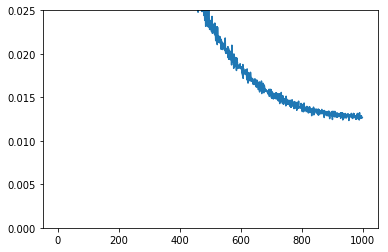

In [99]:
plt.plot(loss_history8[:])
plt.ylim(0,.025)

##### Comparing answers

In [64]:
ar1,ar2 = sess.run([my_y6[:10,:2],correct_y6[:10,:2]])
print(ar1,  "\n",  ar2)

[[ 0.3012674   0.19340295]
 [ 0.2817847   0.070788  ]
 [ 0.09783512  0.12475628]
 [ 0.31322572 -0.02650197]
 [-0.0175496   0.19126132]
 [ 0.11954391  0.01185527]
 [ 0.16998702 -0.12744467]
 [ 0.34755647 -0.19660783]
 [-0.17921686 -0.03275163]
 [ 0.06125247 -0.05411674]] 
 [[ 0.05  0.  ]
 [ 0.05 -0.  ]
 [ 0.05  0.  ]
 [ 0.05 -0.  ]
 [ 0.05  0.  ]
 [ 0.05 -0.  ]
 [ 0.05  0.  ]
 [ 0.05 -0.  ]
 [ 0.05  0.  ]
 [ 0.05 -0.  ]]


In [104]:
tryres=[[],[]]
for _ in range(5):
    trytryres=sess.run([my_y8,correct_y8])
    tryres[0].extend(trytryres[0])
    tryres[1].extend(trytryres[1])
tryres[0]=np.vstack(tryres[0])
tryres[1]=np.vstack(tryres[1])

trydif=np.sum(np.array(tryres)*np.array([1,-1])[:,None,None],axis=0)
print(np.min(trydif[:,0]), np.max(trydif[:,0]))
print(tryres[0][np.argmin(trydif[:,0]),:2],tryres[1][np.argmin(trydif[:,0]),:2])
print(tryres[0][np.argmax(trydif[:,0]),:2],tryres[1][np.argmax(trydif[:,0]),:2])
print('---')
print(np.min(trydif[:,1]), np.max(trydif[:,1]))
print(tryres[0][np.argmin(trydif[:,1]),:2],tryres[1][np.argmin(trydif[:,0]),:2])
print(tryres[0][np.argmax(trydif[:,1]),:2],tryres[1][np.argmax(trydif[:,0]),:2])


-0.15818122029304504 0.14181878417730331
[0.04181878 0.03554685] [ 0.2 -0. ]
[0.04181878 0.03554685] [-0.1 -0.3]
---
-0.2644531577825546 0.3355468660593033
[0.04181878 0.03554685] [ 0.2 -0. ]
[0.04181878 0.03554685] [-0.1 -0.3]


In [102]:
tryres=[[],[]]
for _ in range(5):
    trytryres=sess.run([my_y7,correct_y7])
    tryres[0].extend(trytryres[0])
    tryres[1].extend(trytryres[1])
tryres[0]=np.vstack(tryres[0])
tryres[1]=np.vstack(tryres[1])

trydif=np.sum(np.array(tryres)*np.array([1,-1])[:,None,None],axis=0)
print(np.min(trydif[:,0]), np.max(trydif[:,0]))
print(tryres[0][np.argmin(trydif[:,0]),:2],tryres[1][np.argmin(trydif[:,0]),:2])
print(tryres[0][np.argmax(trydif[:,0]),:2],tryres[1][np.argmax(trydif[:,0]),:2])
print('---')
print(np.min(trydif[:,1]), np.max(trydif[:,1]))
print(tryres[0][np.argmin(trydif[:,1]),:2],tryres[1][np.argmin(trydif[:,0]),:2])
print(tryres[0][np.argmax(trydif[:,1]),:2],tryres[1][np.argmax(trydif[:,0]),:2])


-0.15000347793102264 0.14999652653932571
[4.9996525e-02 2.6104397e-05] [0.2 0. ]
[4.9996525e-02 2.6104397e-05] [-0.1  0.3]
---
-0.29997390752396313 0.3000261163178948
[4.9996525e-02 2.6104397e-05] [0.2 0. ]
[4.9996525e-02 2.6104397e-05] [-0.1  0.3]


In [ ]:
# example from https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428

#prediction = tf.layers.dense(net, 1, activation=tf.tanh)
#loss = tf.losses.mean_squared_error(prediction, y) # pass the second value from iter.get_net() as label
#train_op = tf.train.AdamOptimizer().minimize(loss)
#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
#    for i in range(EPOCHS):
#        _, loss_value = sess.run([train_op, loss])
#        print("Iter: {}, Loss: {:.4f}".format(i, loss_value))

### v2: use layers B,C,D [sql7,3,1]  (exec first two)

In [12]:

def appended_model_v2(XB,XC,XD, reuse=True):
    '''input: XB,XC, XD - input from layers B,C,D of squeezenet
    returns: layers[0...6]'''
    layers=[]
    var_list=[] # list of variable tensors so that we can initialize variables for a particular model
    with tf.variable_scope('my_v2', reuse=reuse):
        x=XD #55x55x16
        with tf.variable_scope('layer0-D'):
            W = tf.get_variable("weights",shape=[1,1,16,10])
            b = tf.get_variable("bias",shape=[10])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 1:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 2:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 32x32x10
            
        #this now has the same HW dimension as layer C (which is 27x27x32) :
        x = tf.concat([x,XC], 3)   
        with tf.variable_scope('layer3-C'):
            W = tf.get_variable("weights",shape=[1,1,42,12])
            b = tf.get_variable("bias",shape=[12])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 4:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 5:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 27x27x12
        #
        x  = tf.concat([x,XB], 3)   
        with tf.variable_scope('layer6-B'):
            W = tf.get_variable("weights",shape=[1,1,76,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 7:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        with tf.variable_scope('layer8'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 9:
            x = tf.nn.relu(x)
            layers.append(x)
        with tf.variable_scope('layer10'):
            W = tf.get_variable("weights",shape=[1,1,18,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 11:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        #fully connected layer:
        with tf.variable_scope('layer12'):
            W = tf.get_variable("weights",shape=[13,13,6,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,13,13,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
    return layers, var_list
                
  

In [13]:
def appended_full_model_v2(filename="XandY1.tfrec", batch_size=2, reuse=True):
    #no coordinates
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    layers, var_list = appended_model_v2( nextdict['squeezed_layer_7'], 
                                          nextdict['squeezed_layer_3'],
                                          nextdict['squeezed_layer_1'], reuse )
    y=tf.reshape(layers[12],[-1,6])
    
    weights=tf.constant([10.,10,0,0,0,0])
    weighted_loss = tf.losses.mean_squared_error( nextdict['Y']*weights, y*weights )
    
    return y, nextdict['Y'], weighted_loss, var_list


In [14]:
def initialize_training(scopename, filename, batch_size=2048,learning_rate=0.003,beta1=0.95):
    with tf.variable_scope(scopename):
        y, correct_y, loss, var_list = appended_full_model_v2(filename=filename, batch_size=batch_size, reuse=False )
        op = tf.train.AdamOptimizer(name="a",learning_rate=learning_rate,beta1=beta1)
        train_op=op.minimize(loss)
        initialize_model(var_list, sess)
        sess.run(tf.variables_initializer(op.variables()))
    return {"y":y, "correct_y":correct_y, "loss":loss, "train_op":train_op, "loss_history": [] }


In [11]:
thisscope="v2-try1"
handles[thisscope] = initialize_training(thisscope,"XBCDandY_9.tfrec")

In [22]:
thisscope="v2-try1"
with tf.variable_scope(thisscope):
    for i in range(2000):
        if i%10==0:
            print ("batch ",i)
        _, loss_value = sess.run([ handles[thisscope]["train_op"], handles[thisscope]["loss"] ])
        handles[thisscope]["loss_history"].append(loss_value)

batch  0
batch  10
batch  20
batch  30
batch  40
batch  50
batch  60
batch  70
batch  80
batch  90
batch  100
batch  110
batch  120
batch  130
batch  140
batch  150
batch  160
batch  170
batch  180
batch  190
batch  200
batch  210


KeyboardInterrupt: 

(0, 20)

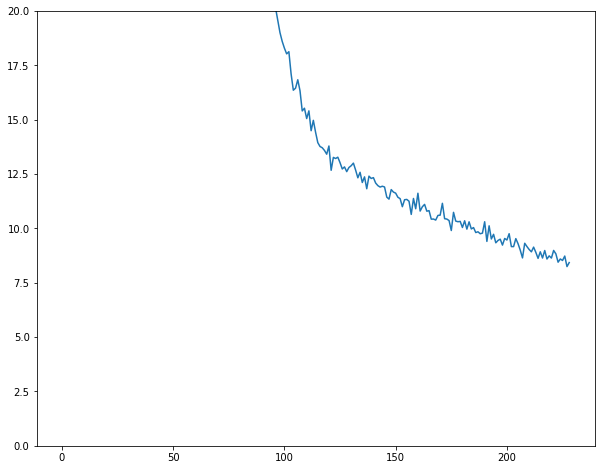

In [46]:
thisscope="v2-try1"
plt.plot(handles[thisscope]["loss_history"][:1000])
plt.ylim(0,20)

### v3: classification using layers B,C,D [sql7,3,1]

##### define

In [15]:

def appended_model_v3(XB,XC,XD, reuse=True):
    '''input: XB,XC, XD - input from layers B,C,D of squeezenet
    returns: layers[0...6]'''
    layers=[]
    var_list=[] # list of variable tensors so that we can initialize variables for a particular model
    with tf.variable_scope('my_v2', reuse=reuse):
        x=XD #55x55x16
        with tf.variable_scope('layer0-D'):
            W = tf.get_variable("weights",shape=[1,1,16,10])
            b = tf.get_variable("bias",shape=[10])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 1:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 2:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 27x27x10
            
        #this now has the same HW dimension as layer C (which is 27x27x32) :
        x = tf.concat([x,XC], 3)   
        with tf.variable_scope('layer3-C'):
            W = tf.get_variable("weights",shape=[1,1,42,12])
            b = tf.get_variable("bias",shape=[12])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 4:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 5:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 27x27x12
        #
        x  = tf.concat([x,XB], 3)   
        with tf.variable_scope('layer6-B'):
            W = tf.get_variable("weights",shape=[1,1,76,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 7:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        with tf.variable_scope('layer8'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 9:
            x = tf.nn.relu(x)
            layers.append(x)
        with tf.variable_scope('layer10'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 11:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        #fully connected layer:
        with tf.variable_scope('layer12'):
            W = tf.get_variable("weights",shape=[13,13,18,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,13,13,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
    return layers, var_list
                
  

In [16]:
def appended_full_model_v3(filename="XandY1.tfrec", batch_size=2, reuse=True):
    
    #no coordinates
    ds=dataset_XYclassif_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    
    layers, var_list = appended_model_v2( nextdict['squeezed_layer_7'], 
                                          nextdict['squeezed_layer_3'],
                                          nextdict['squeezed_layer_1'], reuse )
    y=tf.reshape(layers[-1],[-1,6])
    y_vert = y[:,:3]
    y_horiz = y[:,3:]
    
    loss_vert = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_vert'], 3), 
                                                                        logits=y_vert
                                                                       ))
    loss_horiz = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_horiz'], 3), 
                                                                        logits=y_horiz
                                                                       ))
    loss = loss_vert + loss_horiz
    
    return (y_vert,y_horiz), (nextdict['class_vert'],nextdict['class_horiz']), loss, var_list


#### train

In [15]:
def initialize_training_forfunc(scopename, func, filename, batch_size=1024,learning_rate=0.003,beta1=0.95):
    with tf.variable_scope(scopename):
        y, correct_y, loss, var_list = func(filename=filename, batch_size=batch_size, reuse=False )
        op = tf.train.AdamOptimizer(name="a",learning_rate=learning_rate,beta1=beta1)
        train_op=op.minimize(loss)
        initialize_model(var_list, sess)
        sess.run(tf.variables_initializer(op.variables()))
    return {"y":y, "correct_y":correct_y, "loss":loss, "train_op":train_op, "loss_history": [] }

In [21]:
thisscope="v3-try3"
handles[thisscope] = initialize_training_forfunc(thisscope, appended_full_model_v3, "XBCDandY_4.tfrec")

In [22]:
thisscope="v3-try3"
with tf.variable_scope(thisscope):
    for i in range(100):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.4228515625 %, 	 horiz  0.31640625 %
batch  10	 fit accuracy: vert  0.7587890625 %, 	 horiz  0.439453125 %
batch  20	 fit accuracy: vert  0.7880859375 %, 	 horiz  0.5615234375 %
batch  30	 fit accuracy: vert  0.916015625 %, 	 horiz  0.6494140625 %
batch  40	 fit accuracy: vert  0.962890625 %, 	 horiz  0.7421875 %
batch  50	 fit accuracy: vert  0.9873046875 %, 	 horiz  0.875 %
batch  60	 fit accuracy: vert  0.9931640625 %, 	 horiz  0.9326171875 %
batch  70	 fit accuracy: vert  0.998046875 %, 	 horiz  0.982421875 %
batch  80	 fit accuracy: vert  1.0 %, 	 horiz  0.9873046875 %
batch  90	 fit accuracy: vert  1.0 %, 	 horiz  0.9951171875 %


In [30]:

with tf.variable_scope(thisscope):
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                      "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )

	 fit accuracy: vert  1.0 %, 	 horiz  1.0 %


(0, 5)

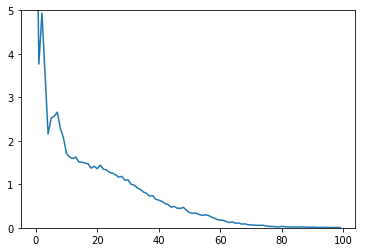

In [35]:
plt.plot(handles[thisscope]["loss_history"][:1000])
plt.ylim(0,5)

In [34]:
loss_value

0.005295509

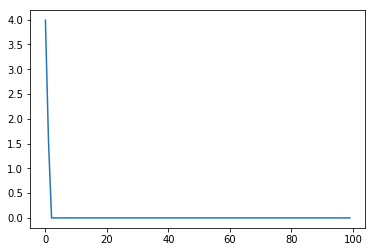

In [26]:
plt.plot(handles["v3-try2"]["loss_history"][:1000])

In [36]:
thisscope="v3-try1"
with tf.variable_scope(thisscope):
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                      "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )

	 fit accuracy: vert  0.4609375 %, 	 horiz  0.3955078125 %


(0, 10)

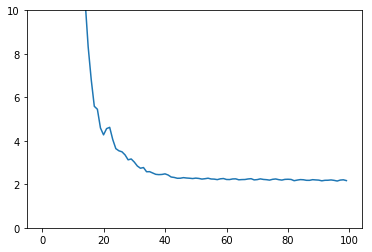

In [29]:
plt.plot(handles["v3-try1"]["loss_history"][:1000])
plt.ylim(0,10)

In [43]:
_, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
print ("fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )


fit accuracy: vert  0.99609375 %, 	 horiz  1.0 %


## normalization exec

##### brainstorm

In [2]:
import numpy as np

In [3]:
a=np.random.random( (200,5,5,16))*np.random.random()*10+(np.random.random()*10-5)

In [9]:
for i in range(15):
    a[:,:,:,i] -= np.mean(a[:,:,:,i])
    a[:,:,:,i] /= np.std(a[:,:,:,i])


In [7]:
a,b,c = np.random.rand(4,5,4,4),np.random.rand(4,5,4,4),np.random.rand(4,5,4,4)
print(np.mean(a, axis=(0,1,2)), np.mean(b, axis=(0,1,2)), np.mean(c, axis=(0,1,2)))
a1,b1,c1 = normalize_all(a,b,c)
print(a1,b1,c1)

[0.50487024 0.50879111 0.52172632 0.48474569] [0.53803298 0.48891019 0.46400435 0.48289704] [0.46780977 0.45027463 0.51190159 0.50773672]


IndexError: arrays used as indices must be of integer (or boolean) type

##### calc averages (exec)

In [8]:
def tftonp(filename, batch_size):
    
    
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    
    dataset = ds.repeat().batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    
    dctn = sess.run(next_element)
    XB,XC,XD = dctn['squeezed_layer_1'],dctn['squeezed_layer_3'],dctn['squeezed_layer_7']
    
    
    averageb,stdb = normalize_num(XB)
    averagec,stdc = normalize_num(XC)
    averaged,stdd = normalize_num(XD)
    return averageb,stdb,averagec,stdc,averaged,stdd

    


In [9]:


def normalize_xb(XB):
    average = np.mean(XB, axis=(0,1,2))
    std = np.std(XB, axis=(0,1,2))
    normXB = (XB-average)/std
    return normXB

def normalize3(XB,XC,XD):
    return normalize_xb(XB),normalize_xb(XC),normalize_xb(XD)

def normalize_num(layer):
    average = np.mean(layer, axis=(0,1,2))
    std = np.std(layer, axis=(0,1,2))
    return average, std

def normalize_total(layer,average,std):
    normlayer = (layer-average)/std
    return normlayer

###### averages calcsection

In [14]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 22AD-19D4

 Directory of C:\Users\Misha\Documents\jupyter\squeezenet

02-Feb-19  04:35 PM    <DIR>          .
02-Feb-19  04:35 PM    <DIR>          ..
31-Dec-18  02:23 PM    <DIR>          .ipynb_checkpoints
15-Dec-18  04:13 PM    <DIR>          classifiers
02-Feb-19  04:20 PM    <DIR>          datasets
13-Nov-18  06:10 PM    <DIR>          example_picture
07-Oct-18  03:10 PM         5,167,371 fromSqueezeNet-v0.ipynb
23-Oct-18  05:47 PM         4,013,965 fromSqueezeNet-v2.ipynb
28-Oct-18  06:08 PM           462,312 fromSqueezeNet-v3.ipynb
15-Dec-18  04:02 PM         2,443,470 fromSqueezeNet-v4.ipynb
30-Dec-18  08:28 PM         3,481,577 fromSqueezeNet-v5-fix.ipynb
31-Dec-18  02:03 PM           269,601 fromSqueezeNet-v6.ipynb
02-Feb-19  04:35 PM         3,272,532 fromSqueezeNet-v7p1.ipynb
21-Jan-19  08:45 PM           313,712 fromSqueezeNet-v7p2.ipynb
03-Nov-18  03:17 PM               771 os.txt
11-Nov-18  10:47 PM             6,

###### calculations

In [20]:
os.chdir("C:\\Users\\Misha\\Documents\\blender\\testpic4")

In [41]:
averages_nf160 = tftonp('noflip160_train.tfrec',1000)

In [27]:
averages_norm160 = tftonp('stable160_train.tfrec',1000)

In [21]:
averages_150 = tftonp('simple150_train.tfrec', 4600)

In [47]:
averages_train160 = tftonp('trainonly160_train.tfrec',1000)

In [15]:
averages_xbc4 = tftonp('XBCDandY_4.tfrec', 4600)

In [11]:
averages_xbc90 = tftonp('XBCDandY_90.tfrec', 4600)

###### normaliz all old

In [8]:

def normalize_all(XB,XC,XD):
    
    
    average1final = np.zeros(16)
    average3final = np.zeros(32)
    average7final = np.zeros(64) 
    std1final = np.zeros(16)
    std3final = np.zeros(32)
    std7final = np.zeros(64) 
    
    

        
    for k in range(len(XB[])):
        j = XB[:,:,:,k]
        average1 = np.mean(j, axis=(0,1,2))
        std1 = np.std(j,axis=(0,1,2))
        #average1final[k] = (average1final[k]+average1)
        #std1final[k] = (std1final[k]+std1)

    for k in XC:
        j = XC[k]
        average3 = np.mean(j, axis=(0,1,2))
        std3 = np.std(j,axis=(0,1,2))
        #average3final[k] = (average3final[k]+average3)
        #std3final[k] = (std3final[k]+std3)


    for k in XD:
        j = XD[k]
        average7 = np.mean(j, axis=(0,1,2))
        std7 = np.std(j,axis=(0,1,2))
        #average7final[k] = (average7final[k]+average7)
        #std7final[k] = (std7final[k]+std7)
    

    
    
    normalized1 = (XB-average1)/std1
    normalized3 = (XB-average3)/std3
    normalized7 = (XB-average7)/std7
    
    return normalized1, normalized3, normalized7


def normalize_all_nbatches(XB,XC,XD, nbatches):
    
    
    average1final = np.zeroes(16)
    average3final = np.zeroes(32)
    average7final = np.zeroes(64) 
    std1final = np.zeroes(16)
    std3final = np.zeroes(32)
    std7final = np.zeroes(64) 
    
    
    for i in range(nbatches):
        
        for k in XB:
            j = XB[k]
            average1 = np.mean(j, axis=(0,1,2))
            std1 = np.std(j,axis=(0,1,2))
            average1final[k] = (average1final[k]+average1)
            std1final[k] = (std1final[k]+std1)
        
        for k in XC:
            j = XC[k]
            average3 = np.mean(j, axis=(0,1,2))
            std3 = np.std(j,axis=(0,1,2))
            average3final[k] = (average3final[k]+average3)
            std3final[k] = (std3final[k]+std3)
            

        for k in XD:
            j = XD[k]
            average7 = np.mean(j, axis=(0,1,2))
            std7 = np.std(j,axis=(0,1,2))
            average7final[k] = (average7final[k]+average7)
            std7final[k] = (std7final[k]+std7)
    
    average1final
    
    
    normalized1 = (XB-average1final)/std1final
    normalized3 = (XB-average3final)/std3final
    normalized7 = (XB-average7final)/std7final
    
    return normalized1, normalized3, normalized7



SyntaxError: invalid syntax (<ipython-input-8-21870262670b>, line 15)

## version 4

In [19]:
def appended_full_model_v4(filename, averages, batch_size=2, reuse=False):
    
    #no coordinates
    ds=dataset_XYclassif_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    a1,s1,a3,s3,a7,s7=averages
    layers, var_list = appended_model_v2( ((nextdict['squeezed_layer_7']-a7)/s7), 
                                          ((nextdict['squeezed_layer_3']-a3)/s3),
                                          ((nextdict['squeezed_layer_1']-a1)/s1), reuse )
    y=tf.reshape(layers[-1],[-1,6])
    y_vert = y[:,:3]
    y_horiz = y[:,3:]
    
    loss_vert = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_vert'], 3), 
                                                                        logits=y_vert
                                                                       ))
    loss_horiz = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_horiz'], 3), 
                                                                        logits=y_horiz
                                                                       ))
    loss = loss_vert + loss_horiz
    
    return (y_vert,y_horiz), (nextdict['class_vert'],nextdict['class_horiz']), loss, var_list

#### train

In [13]:
def initialize_training_forfunc_averages(scopename, func, averages, filename, batch_size=1024,learning_rate=0.003,beta1=0.95, reuse=False, optname="a"):
    with tf.variable_scope(scopename):
        y, correct_y, loss, var_list = func(filename, averages, batch_size=batch_size, reuse=reuse )
        op = tf.train.AdamOptimizer(name=optname,learning_rate=learning_rate,beta1=beta1)
        train_op=op.minimize(loss)
        initialize_model(var_list, sess)
        sess.run(tf.variables_initializer(op.variables()))
    return {"y":y, "correct_y":correct_y, "loss":loss, "train_op":train_op, "loss_history": [], "val_history":[], "fit_history":[]}

##### v4-try1

In [28]:
thisscope="v4-try1"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_xbc4, "XBCDandY_4.tfrec")

###### results

In [29]:
thisscope="v4-try1"
with tf.variable_scope(thisscope):
    for i in range(100):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.2021484375 %, 	 horiz  0.2880859375 %
batch  10	 fit accuracy: vert  0.7802734375 %, 	 horiz  0.4169921875 %
batch  20	 fit accuracy: vert  0.7568359375 %, 	 horiz  0.5009765625 %
batch  30	 fit accuracy: vert  0.8720703125 %, 	 horiz  0.6826171875 %
batch  40	 fit accuracy: vert  0.9990234375 %, 	 horiz  0.892578125 %
batch  50	 fit accuracy: vert  1.0 %, 	 horiz  0.9404296875 %
batch  60	 fit accuracy: vert  1.0 %, 	 horiz  0.9765625 %
batch  70	 fit accuracy: vert  1.0 %, 	 horiz  0.990234375 %
batch  80	 fit accuracy: vert  1.0 %, 	 horiz  0.998046875 %
batch  90	 fit accuracy: vert  1.0 %, 	 horiz  1.0 %


In [30]:

with tf.variable_scope(thisscope):
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                      "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )

	 fit accuracy: vert  1.0 %, 	 horiz  1.0 %


(0, 5)

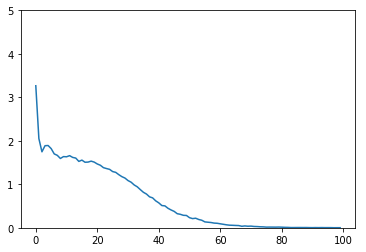

In [31]:
plt.plot(handles[thisscope]["loss_history"][:1000])
plt.ylim(0,5)

##### v4-tr2

In [42]:
thisscope="v4-try4"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_xbc90, "XBCDandY_90.tfrec")

In [44]:
thisscope="v4-try4"
with tf.variable_scope(thisscope):
    for i in range(100):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.2919921875 %, 	 horiz  0.380859375 %
batch  10	 fit accuracy: vert  0.298828125 %, 	 horiz  0.3427734375 %
batch  20	 fit accuracy: vert  0.2744140625 %, 	 horiz  0.345703125 %
batch  30	 fit accuracy: vert  0.4130859375 %, 	 horiz  0.423828125 %
batch  40	 fit accuracy: vert  0.396484375 %, 	 horiz  0.3828125 %
batch  50	 fit accuracy: vert  0.4345703125 %, 	 horiz  0.3740234375 %
batch  60	 fit accuracy: vert  0.427734375 %, 	 horiz  0.404296875 %
batch  70	 fit accuracy: vert  0.513671875 %, 	 horiz  0.35546875 %
batch  80	 fit accuracy: vert  0.7041015625 %, 	 horiz  0.6796875 %
batch  90	 fit accuracy: vert  0.484375 %, 	 horiz  0.4814453125 %


In [45]:

with tf.variable_scope(thisscope):
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                      "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )

	 fit accuracy: vert  0.4697265625 %, 	 horiz  0.591796875 %


(0, 5)

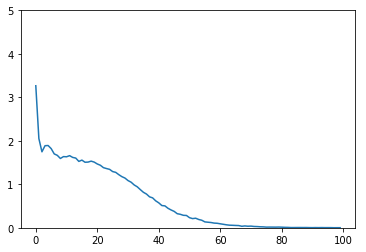

In [31]:
plt.plot(handles[thisscope]["loss_history"][:1000])
plt.ylim(0,5)

##### v4-try4long

In [15]:
thisscope="v4-try4long"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_xbc90, "XBCDandY_90.tfrec", optname="a")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [16]:
thisscope="v4-try4long"
with tf.variable_scope(thisscope):
    for i in range(1000):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.3994140625 %, 	 horiz  0.34375 %
batch  10	 fit accuracy: vert  0.2373046875 %, 	 horiz  0.3115234375 %
batch  20	 fit accuracy: vert  0.2490234375 %, 	 horiz  0.296875 %
batch  30	 fit accuracy: vert  0.392578125 %, 	 horiz  0.4052734375 %
batch  40	 fit accuracy: vert  0.349609375 %, 	 horiz  0.36328125 %
batch  50	 fit accuracy: vert  0.4013671875 %, 	 horiz  0.3984375 %
batch  60	 fit accuracy: vert  0.4716796875 %, 	 horiz  0.4423828125 %
batch  70	 fit accuracy: vert  0.3251953125 %, 	 horiz  0.376953125 %
batch  80	 fit accuracy: vert  0.580078125 %, 	 horiz  0.5556640625 %
batch  90	 fit accuracy: vert  0.611328125 %, 	 horiz  0.3916015625 %
batch  100	 fit accuracy: vert  0.580078125 %, 	 horiz  0.6064453125 %
batch  110	 fit accuracy: vert  0.49609375 %, 	 horiz  0.462890625 %
batch  120	 fit accuracy: vert  0.63671875 %, 	 horiz  0.5322265625 %
batch  130	 fit accuracy: vert  0.4482421875 %, 	 horiz  0.4287109375 %
batch  140	 fit accuracy: ve

In [17]:

with tf.variable_scope(thisscope):
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                      "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )

	 fit accuracy: vert  0.84765625 %, 	 horiz  0.8544921875 %


(0, 5)

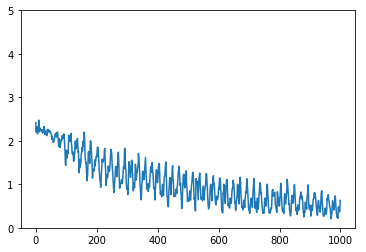

In [18]:
plt.plot(handles[thisscope]["loss_history"][:1000])
plt.ylim(0,5)

## w/ validation

###### functions

In [33]:
def valacc(thisscope, filename, averages, batch):
    with tf.variable_scope(thisscope):
        y , ycor, _, _ = appended_full_model_v4(filename, averages, batch_size=batch, reuse=True)
        
        y_num, ycor_num = sess.run ([y,ycor])
        a,b = np.mean( np.argmax(y_num[0],axis=1) == ycor_num[0] )*100, np.mean( np.argmax(y_num[1],axis=1) == ycor_num[1] )*100 
        print ("\t validation accuracy: vert ",a,  "%, \t horiz ", b,"%" )
        return a,b

In [22]:

def load_train_and_val (train=1, valid=1, test=1, path=__file__, filename="default"):
    generate_XFeat_and_Y_TFRecord(  in_list[:train], my_Xraw[:train], my_Xref[:train],  model, [], [1,3,7], filename=filename+"_train" )
    generate_XFeat_and_Y_TFRecord(  in_list[test:valid], my_Xraw[valid], my_Xref[valid],  model, [], [1,3,7], filename=filename+"_valid" )
    generate_XFeat_and_Y_TFRecord(  in_list[test], my_Xraw[test], my_Xref[test],  model, [], [1,3,7], filename=filename+"_test" )
    

NameError: name '__file__' is not defined

##### trys

###### v4-tryvalid

In [25]:
thisscope="v4-1tryvalid"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_150, "simple150_train.tfrec", optname="b")

In [26]:
thisscope="v4-1tryvalid"
with tf.variable_scope(thisscope):
    for i in range(1000):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.3037109375 %, 	 horiz  0.30859375 %
batch  10	 fit accuracy: vert  0.3017578125 %, 	 horiz  0.3271484375 %
batch  20	 fit accuracy: vert  0.3701171875 %, 	 horiz  0.30859375 %
batch  30	 fit accuracy: vert  0.3798828125 %, 	 horiz  0.4189453125 %
batch  40	 fit accuracy: vert  0.5400390625 %, 	 horiz  0.4130859375 %
batch  50	 fit accuracy: vert  0.455078125 %, 	 horiz  0.4912109375 %
batch  60	 fit accuracy: vert  0.390625 %, 	 horiz  0.4033203125 %
batch  70	 fit accuracy: vert  0.3603515625 %, 	 horiz  0.373046875 %
batch  80	 fit accuracy: vert  0.650390625 %, 	 horiz  0.578125 %
batch  90	 fit accuracy: vert  0.5615234375 %, 	 horiz  0.423828125 %
batch  100	 fit accuracy: vert  0.3486328125 %, 	 horiz  0.52734375 %
batch  110	 fit accuracy: vert  0.3837890625 %, 	 horiz  0.5791015625 %
batch  120	 fit accuracy: vert  0.7431640625 %, 	 horiz  0.642578125 %
batch  130	 fit accuracy: vert  0.609375 %, 	 horiz  0.4921875 %
batch  140	 fit accuracy: ver

In [37]:
for i in range(5):
    valacc(thisscope, "simple150_valid.tfrec", averages_150, 2000)

	 validation accuracy: vert  0.519 %, 	 horiz  0.467 %
	 validation accuracy: vert  0.512 %, 	 horiz  0.475 %
	 validation accuracy: vert  0.516 %, 	 horiz  0.477 %
	 validation accuracy: vert  0.523 %, 	 horiz  0.493 %
	 validation accuracy: vert  0.5115 %, 	 horiz  0.489 %


###### try-5

In [28]:
thisscope="v4-cmpltnrm"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_norm160, "stable160_train.tfrec", optname="a")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [29]:
thisscope="v4-cmpltnrm"
with tf.variable_scope(thisscope):
    for i in range(1):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.326171875 %, 	 horiz  0.3798828125 %
batch  10	 fit accuracy: vert  0.416015625 %, 	 horiz  0.3603515625 %
batch  20	 fit accuracy: vert  0.546875 %, 	 horiz  0.4892578125 %
batch  30	 fit accuracy: vert  0.6279296875 %, 	 horiz  0.599609375 %
batch  40	 fit accuracy: vert  0.7119140625 %, 	 horiz  0.6572265625 %
batch  50	 fit accuracy: vert  0.7744140625 %, 	 horiz  0.708984375 %
batch  60	 fit accuracy: vert  0.82421875 %, 	 horiz  0.7822265625 %
batch  70	 fit accuracy: vert  0.8828125 %, 	 horiz  0.8515625 %
batch  80	 fit accuracy: vert  0.9140625 %, 	 horiz  0.890625 %
batch  90	 fit accuracy: vert  0.94921875 %, 	 horiz  0.9384765625 %
batch  100	 fit accuracy: vert  0.962890625 %, 	 horiz  0.9638671875 %
batch  110	 fit accuracy: vert  0.984375 %, 	 horiz  0.9873046875 %
batch  120	 fit accuracy: vert  0.9892578125 %, 	 horiz  0.9912109375 %
batch  130	 fit accuracy: vert  0.99609375 %, 	 horiz  0.9970703125 %
batch  140	 fit accuracy: vert  0.9

KeyboardInterrupt: 

(0, 0.05)

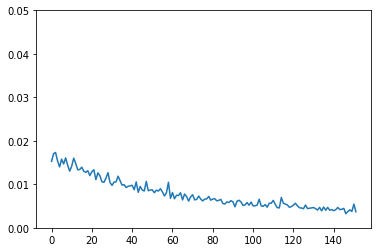

In [39]:
plt.plot(handles[thisscope]["loss_history"][200:1000])
plt.ylim(0,.05)

In [34]:
valacc(thisscope, "stable160_test.tfrec", averages_norm160, 2000)

	 validation accuracy: vert  50.1 %, 	 horiz  45.95 %


###### v4-noflip

In [43]:
thisscope="v4-noflip1"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_nf160, "noflip160_train.tfrec", optname="a")

In [44]:
thisscope="v4-noflip1"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000)
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.33984375 %, 	 horiz  0.3896484375 %
batch  10	 fit accuracy: vert  0.3662109375 %, 	 horiz  0.3447265625 %
batch  20	 fit accuracy: vert  0.3671875 %, 	 horiz  0.39453125 %
batch  30	 fit accuracy: vert  0.4404296875 %, 	 horiz  0.4873046875 %
batch  40	 fit accuracy: vert  0.5478515625 %, 	 horiz  0.5224609375 %
batch  50	 fit accuracy: vert  0.6181640625 %, 	 horiz  0.5966796875 %
batch  60	 fit accuracy: vert  0.6982421875 %, 	 horiz  0.6396484375 %
batch  70	 fit accuracy: vert  0.73828125 %, 	 horiz  0.7060546875 %
batch  80	 fit accuracy: vert  0.7890625 %, 	 horiz  0.75 %
batch  90	 fit accuracy: vert  0.82421875 %, 	 horiz  0.8056640625 %
batch  100	 fit accuracy: vert  0.8408203125 %, 	 horiz  0.8427734375 %
batch  110	 fit accuracy: vert  0.8935546875 %, 	 horiz  0.8984375 %
batch  120	 fit accuracy: vert  0.912109375 %, 	 horiz  0.904296875 %
batch  130	 fit accuracy: vert  0.943359375 %, 	 horiz  0.96484375 %
batch  140	 fit accuracy: vert  0

KeyboardInterrupt: 

In [46]:
valacc(thisscope, "stable160_test.tfrec", averages_norm160, 500)

	 validation accuracy: vert  47.599999999999994 %, 	 horiz  39.0 %


###### v4-train160

In [52]:
thisscope="v4-train160-1"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_train160, "noflip160_train.tfrec", optname="b")

In [54]:
thisscope="v4-train160-1"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            #handles[thisscope]["fit_history"].append((a,b))
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.37109375 %, 	 horiz  0.3671875 %
batch  10	 fit accuracy: vert  0.408203125 %, 	 horiz  0.3818359375 %
batch  20	 fit accuracy: vert  0.5107421875 %, 	 horiz  0.4443359375 %
batch  30	 fit accuracy: vert  0.5390625 %, 	 horiz  0.4931640625 %
batch  40	 fit accuracy: vert  0.61328125 %, 	 horiz  0.6123046875 %
batch  50	 fit accuracy: vert  0.6865234375 %, 	 horiz  0.677734375 %
batch  60	 fit accuracy: vert  0.7490234375 %, 	 horiz  0.732421875 %
batch  70	 fit accuracy: vert  0.8115234375 %, 	 horiz  0.765625 %
batch  80	 fit accuracy: vert  0.833984375 %, 	 horiz  0.8125 %
batch  90	 fit accuracy: vert  0.8779296875 %, 	 horiz  0.849609375 %
batch  100	 fit accuracy: vert  0.93359375 %, 	 horiz  0.8955078125 %
batch  110	 fit accuracy: vert  0.9658203125 %, 	 horiz  0.9404296875 %


KeyboardInterrupt: 

In [55]:
valacc(thisscope, "only9_train.tfrec", averages_norm160, 500)

	 validation accuracy: vert  62.8 %, 	 horiz  63.2 %


(62.8, 63.2)

###### v4-try1000

In [15]:
averages_1000 = tftonp('1000_train.tfrec',1000)

In [23]:
thisscope="v4-train1000"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_1000, "1000_train.tfrec", optname="a")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [24]:
thisscope="v4-train1000"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            #handles[thisscope]["fit_history"].append((a,b))
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.3388671875 %, 	 horiz  0.31640625 %
batch  10	 fit accuracy: vert  0.380859375 %, 	 horiz  0.38671875 %
batch  20	 fit accuracy: vert  0.4541015625 %, 	 horiz  0.4326171875 %
batch  30	 fit accuracy: vert  0.5634765625 %, 	 horiz  0.4873046875 %
batch  40	 fit accuracy: vert  0.59765625 %, 	 horiz  0.4951171875 %
batch  50	 fit accuracy: vert  0.5908203125 %, 	 horiz  0.5361328125 %
batch  60	 fit accuracy: vert  0.6669921875 %, 	 horiz  0.5703125 %
batch  70	 fit accuracy: vert  0.6904296875 %, 	 horiz  0.57421875 %
batch  80	 fit accuracy: vert  0.7177734375 %, 	 horiz  0.57421875 %
batch  90	 fit accuracy: vert  0.7431640625 %, 	 horiz  0.5908203125 %
batch  100	 fit accuracy: vert  0.7421875 %, 	 horiz  0.65625 %
batch  110	 fit accuracy: vert  0.7724609375 %, 	 horiz  0.6630859375 %
batch  120	 fit accuracy: vert  0.78515625 %, 	 horiz  0.66015625 %
batch  130	 fit accuracy: vert  0.7734375 %, 	 horiz  0.69140625 %
batch  140	 fit accuracy: vert  0.

In [25]:
valacc(thisscope, "1000_test.tfrec", averages_1000, 500)

	 validation accuracy: vert  59.8 %, 	 horiz  49.4 %


(59.8, 49.4)

(0, 1)

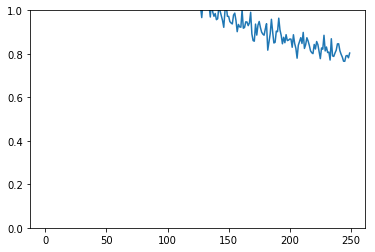

In [29]:
plt.plot(handles[thisscope]["loss_history"][50:])
plt.ylim(0,1)

In [30]:
thisscope="v4-train1001"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_1000, "1000_train.tfrec", optname="a")

In [31]:
thisscope="v4-train1001"
with tf.variable_scope(thisscope):
    for i in range(500):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            #handles[thisscope]["fit_history"].append((a,b))
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.3720703125 %, 	 horiz  0.3583984375 %
batch  10	 fit accuracy: vert  0.369140625 %, 	 horiz  0.3515625 %
batch  20	 fit accuracy: vert  0.5185546875 %, 	 horiz  0.3984375 %
batch  30	 fit accuracy: vert  0.5830078125 %, 	 horiz  0.44140625 %
batch  40	 fit accuracy: vert  0.638671875 %, 	 horiz  0.5068359375 %
batch  50	 fit accuracy: vert  0.6396484375 %, 	 horiz  0.5029296875 %
batch  60	 fit accuracy: vert  0.6904296875 %, 	 horiz  0.515625 %
batch  70	 fit accuracy: vert  0.697265625 %, 	 horiz  0.564453125 %
batch  80	 fit accuracy: vert  0.7607421875 %, 	 horiz  0.6044921875 %
batch  90	 fit accuracy: vert  0.720703125 %, 	 horiz  0.5625 %
batch  100	 fit accuracy: vert  0.76171875 %, 	 horiz  0.6005859375 %
batch  110	 fit accuracy: vert  0.8056640625 %, 	 horiz  0.6435546875 %
batch  120	 fit accuracy: vert  0.77734375 %, 	 horiz  0.607421875 %
batch  130	 fit accuracy: vert  0.8037109375 %, 	 horiz  0.6708984375 %
batch  140	 fit accuracy: vert 

In [32]:
valacc(thisscope, "1000_test.tfrec", averages_1000, 500)

	 validation accuracy: vert  62.0 %, 	 horiz  51.800000000000004 %


(62.0, 51.800000000000004)

(0, 1)

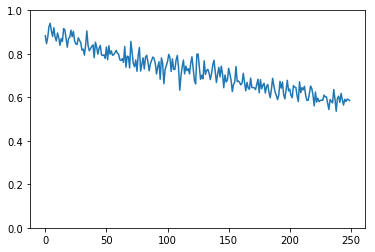

In [38]:
plt.plot(handles[thisscope]["loss_history"][250:])
plt.ylim(0,1)

(0, 2.8)

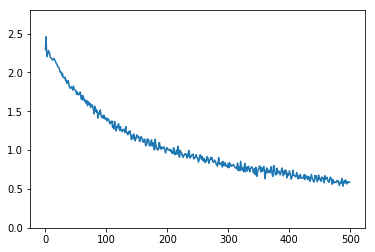

In [39]:
plt.plot(handles[thisscope]["loss_history"][:])
plt.ylim(0,2.8)

In [40]:
valacc(thisscope, "1000_test.tfrec", averages_1000, 1000)

	 validation accuracy: vert  62.6 %, 	 horiz  48.3 %


(62.6, 48.3)

### EXEC v4a (previous v4 used appendedmodel 2)

In [10]:

def appended_model_v4_extended(XB,XC,XD, reuse=True):
    '''input: XB,XC, XD - input from layers B,C,D of squeezenet
    returns: layers[0...6]'''
    layers=[]
    var_list=[] # list of variable tensors so that we can initialize variables for a particular model
    with tf.variable_scope('my_v2', reuse=reuse):
        x=XD #55x55x16
        with tf.variable_scope('layer0-D'):
            W = tf.get_variable("weights",shape=[1,1,16,10])
            b = tf.get_variable("bias",shape=[10])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 1:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 2:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 27x27x10
            
        #this now has the same HW dimension as layer C (which is 27x27x32) :
        x = tf.concat([x,XC], 3) #3 is axis   
        with tf.variable_scope('layer3-C'):
            W = tf.get_variable("weights",shape=[1,1,42,24])
            b = tf.get_variable("bias",shape=[24])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 4:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 5:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,1,1,1],padding='VALID')
            layers.append(x)
            # x now is 25x25x12
            
        with tf.variable_scope('layerc-b'):
            W = tf.get_variable("weights",shape=[1,1,12,12])
            b = tf.get_variable("bias",shape=[12])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 6:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 7:
            x = tf.nn.max_pool(x,[1,13,13,1],strides=[1,1,1,1],padding='VALID')
            layers.append(x)
        
        
        #XB is  13x13x64
        x  = tf.concat([x,XB], 3)   
        with tf.variable_scope('layer6-B'):
            W = tf.get_variable("weights",shape=[1,1,76,24])
            b = tf.get_variable("bias",shape=[24])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 7:
            x = tf.nn.relu(x)
            layers.append(x)
        #x is 13x13x18
        with tf.variable_scope('layer8'):
            W = tf.get_variable("weights",shape=[1,1,24,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 9:
            x = tf.nn.relu(x)
            layers.append(x)
        #x has shape 13x13x18
        
        with tf.variable_scope('layer10'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 11:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        #fully connected layer:
        with tf.variable_scope('layer12'):
            W = tf.get_variable("weights",shape=[1,1,18,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,13,13,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)

        with tf.variable_scope('layer13'):
            W = tf.get_variable("weights",shape=[1,1,6,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,13,13,1],"VALID")
            x = tf.nn.bias_add(x,b)
            x = tf.nn.relu(x)
            layers.append(x)

            
            
    return layers, var_list
                
  

In [11]:

def appended_model_v4_avgpool(XB,XC,XD, reuse=True):
    '''input: XB,XC, XD - input from layers B,C,D of squeezenet
    returns: layers[0...6]'''
    layers=[]
    var_list=[] # list of variable tensors so that we can initialize variables for a particular model
    with tf.variable_scope('my_v2', reuse=reuse):
        x=XD #55x55x16
        with tf.variable_scope('layer0-D'):
            W = tf.get_variable("weights",shape=[1,1,16,10])
            b = tf.get_variable("bias",shape=[10])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 1:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 2:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 27x27x10
            
        #this now has the same HW dimension as layer C (which is 27x27x32) :
        x = tf.concat([x,XC], 3) #3 is axis   
        with tf.variable_scope('layer3-C'):
            W = tf.get_variable("weights",shape=[1,1,42,12])
            b = tf.get_variable("bias",shape=[12])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 4:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 5:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 13x13x12
        #XB is  13x13x64
        x  = tf.concat([x,XB], 3)   
        with tf.variable_scope('layer6-B'):
            W = tf.get_variable("weights",shape=[1,1,76,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 7:
            x = tf.nn.relu(x)
            layers.append(x)
        #x is 13x13x18
        with tf.variable_scope('layer8'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 9:
            x = tf.nn.relu(x)
            layers.append(x)
        #x has shape 13x13x18
        
        with tf.variable_scope('layer10'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 11:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        #averagepool:
        with tf.variable_scope('layer12'):
            x = tf.nn.avg_pool(x,[1,13,13,1],strides=[1,1,1,1],padding = "VALID")
            layers.append(x)
            W = tf.get_variable("weights",shape=[1,1,18,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            layers.append(x)
    return layers, var_list
                
  

In [12]:
def appended_full_model_v5( filename, averages, batch_size=2, regscale=0., reuse=False):
    
    #no coordinates
    ds=dataset_XYclassif_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    a1,s1,a3,s3,a7,s7=averages
    layers, var_list = appended_model_v4_avgpool( ((nextdict['squeezed_layer_7']-a7)/s7), 
                                          ((nextdict['squeezed_layer_3']-a3)/s3),
                                          ((nextdict['squeezed_layer_1']-a1)/s1), reuse )
    y=tf.reshape(layers[-1],[-1,6])
    y_vert = y[:,:3]
    y_horiz = y[:,3:]
    
    reg_loss = tf.add_n([.5 *regscale * tf.reduce_sum(h**2)   for h in var_list])
    
    loss_vert = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_vert'], 3), 
                                                                        logits=y_vert
                                                                       ))
    loss_horiz = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_horiz'], 3), 
                                                                        logits=y_horiz
                                                                       ))
    loss = loss_vert + loss_horiz + reg_loss
    
    return (y_vert,y_horiz), (nextdict['class_vert'],nextdict['class_horiz']), loss, var_list

In [16]:
def appended_full_model_v5_extended( filename, averages, batch_size=2, regscale=0., reuse=False):
    
    #no coordinates
    ds=dataset_XYclassif_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    a1,s1,a3,s3,a7,s7=averages
    layers, var_list = appended_model_v4_extended( ((nextdict['squeezed_layer_7']-a7)/s7), 
                                          ((nextdict['squeezed_layer_3']-a3)/s3),
                                          ((nextdict['squeezed_layer_1']-a1)/s1), reuse )
    y=tf.reshape(layers[-1],[-1,6])
    y_vert = y[:,:3]
    y_horiz = y[:,3:]
    
    reg_loss = tf.add_n([.5 *regscale * tf.reduce_sum(h**2)   for h in var_list])
    
    loss_vert = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_vert'], 3), 
                                                                        logits=y_vert
                                                                       ))
    loss_horiz = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_horiz'], 3), 
                                                                        logits=y_horiz
                                                                       ))
    loss = loss_vert + loss_horiz + reg_loss
    
    return (y_vert,y_horiz), (nextdict['class_vert'],nextdict['class_horiz']), loss, var_list

###### v4_averages-1004

In [48]:
thisscope="v4_averages-train1004"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v5, averages_1000, "1000_train.tfrec", optname="g")

In [46]:
def valacc_v4(thisscope, filename, averages, batch):

    y , ycor, _, _ = appended_full_model_v5(filename, averages, batch_size=batch, reuse=True)

    y_num, ycor_num = sess.run ([y,ycor])
    a,b = np.mean( np.argmax(y_num[0],axis=1) == ycor_num[0] )*100, np.mean( np.argmax(y_num[1],axis=1) == ycor_num[1] )*100 
    print ("\t validation accuracy: vert ",a,  "%, \t horiz ", b,"%" )
    return a,b

In [50]:
thisscope="v4_averages-train1004"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%50==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            c,d = valacc_v4(thisscope, "1000_valid.tfrec", averages_1000, 500)
            
            #handles[thisscope]["fit_history"].append((a,b))
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.3271484375 %, 	 horiz  0.3447265625 %
	 validation accuracy: vert  36.8 %, 	 horiz  30.4 %
batch  10	 fit accuracy: vert  0.36328125 %, 	 horiz  0.3583984375 %
	 validation accuracy: vert  34.2 %, 	 horiz  34.8 %
batch  20	 fit accuracy: vert  0.3759765625 %, 	 horiz  0.3212890625 %
	 validation accuracy: vert  40.6 %, 	 horiz  35.8 %
batch  30	 fit accuracy: vert  0.345703125 %, 	 horiz  0.390625 %
	 validation accuracy: vert  36.0 %, 	 horiz  39.6 %
batch  40	 fit accuracy: vert  0.421875 %, 	 horiz  0.3720703125 %
	 validation accuracy: vert  43.0 %, 	 horiz  37.8 %
batch  50	 fit accuracy: vert  0.44921875 %, 	 horiz  0.3876953125 %
	 validation accuracy: vert  51.800000000000004 %, 	 horiz  34.2 %
batch  60	 fit accuracy: vert  0.4580078125 %, 	 horiz  0.396484375 %


KeyboardInterrupt: 

### train and validation simultaneously

In [13]:
def initialize_training_forfunc_averages_validtn(scopename, func, averages, trainfile, valfile, batch_size=1024,learning_rate=0.003,beta1=0.95, reuse=False, optname="a", validate=False):
    with tf.variable_scope(scopename):
        y, correct_y, loss, var_list = func(trainfile, averages, batch_size=batch_size, reuse=reuse )
        val_y, val_correct_y, val_loss, val_var_list = func(valfile, averages, batch_size=batch_size, reuse=True )
        op = tf.train.AdamOptimizer(name=optname,learning_rate=learning_rate,beta1=beta1)
        train_op=op.minimize(loss)
        initialize_model(var_list, sess)
        initialize_model(val_var_list, sess)
        sess.run(tf.variables_initializer(op.variables()))
    return {"y":y, "correct_y":correct_y, "loss":loss, "train_op":train_op, "loss_history": [], "val_history_x":[], "val_history_y":[],
            "fit_history_x":[], "fit_history_y":[], "val_y":val_y, "val_correct_y": val_correct_y, "val_loss": val_loss}

###### v5-try1

In [15]:
averages_1000 = tftonp('1000_train.tfrec',1000)

In [17]:
thisscope="v5-try1"
handles[thisscope] = initialize_training_forfunc_averages_validtn(thisscope, appended_full_model_v5, averages_1000, "1000_train.tfrec", "1000_valid.tfrec", optname="a")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [ ]:
def valacc_v4(thisscope, filename, averages, batch):

    y , ycor, _, _ = appended_full_model_v5(filename, averages, batch_size=batch, reuse=True)

    y_num, ycor_num = sess.run ([y,ycor])
    a,b = np.mean( np.argmax(y_num[0],axis=1) == ycor_num[0] )*100, np.mean( np.argmax(y_num[1],axis=1) == ycor_num[1] )*100 
    print ("\t validation accuracy: vert ",a,  "%, \t horiz ", b,"%" )
    return a,b

In [ ]:
thisscope="v4_averages-train1004"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%50==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            y_num, ycor_num = sess.run ([y,cor_y])
            first, second = np.mean( np.argmax(y_num[0],axis=1) == ycor_num[0] ), np.mean( np.argmax(y_num[1],axis=1) == ycor_num[1] ))
            print ("\t validation accuracy: vert ",first,  "%, \t horiz ", second,"%" )
            
            handles[thisscope]["val_history_y"].append(second)
            handles[thisscope]["val_history_x"].append(first)
            handles[thisscope]["fit_history_x"].append(a)
            handles[thisscope]["fit_history_y"].append(b)
            
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
            handles[thisscope]["loss_history"].append(loss_value)
        

In [18]:
thisscope="v5-try1"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y, val_his = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"],
                                             handles[thisscope]["val_history"]] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            #handles[thisscope]["fit_history"].append((a,b))
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
        handles[thisscope]["loss_history"].append(loss_value)
        handles[thisscope]["val_history"].append(val_his)

batch  0	 fit accuracy: vert  0.322265625 %, 	 horiz  0.3408203125 %
batch  10	 fit accuracy: vert  0.341796875 %, 	 horiz  0.3447265625 %
batch  20	 fit accuracy: vert  0.32421875 %, 	 horiz  0.3564453125 %
batch  30	 fit accuracy: vert  0.435546875 %, 	 horiz  0.369140625 %
batch  40	 fit accuracy: vert  0.43359375 %, 	 horiz  0.38671875 %
batch  50	 fit accuracy: vert  0.4580078125 %, 	 horiz  0.3857421875 %
batch  60	 fit accuracy: vert  0.4765625 %, 	 horiz  0.43359375 %
batch  70	 fit accuracy: vert  0.5009765625 %, 	 horiz  0.439453125 %
batch  80	 fit accuracy: vert  0.5615234375 %, 	 horiz  0.4228515625 %
batch  90	 fit accuracy: vert  0.5615234375 %, 	 horiz  0.43359375 %
batch  100	 fit accuracy: vert  0.5537109375 %, 	 horiz  0.4326171875 %
batch  110	 fit accuracy: vert  0.5849609375 %, 	 horiz  0.4599609375 %
batch  120	 fit accuracy: vert  0.6171875 %, 	 horiz  0.466796875 %
batch  130	 fit accuracy: vert  0.6220703125 %, 	 horiz  0.4833984375 %
batch  140	 fit accuracy:

In [17]:
thisscope="v5-try1-e"
handles[thisscope] = initialize_training_forfunc_averages_validtn(thisscope, appended_full_model_v5_extended, averages_1000, "1000_train.tfrec", "1000_valid.tfrec", optname="a")

ValueError: Dimensions must be equal, but are 24 and 12 for 'v5-try1-e/my_v2/layerc-b/Conv2D' (op: 'Conv2D') with input shapes: [?,25,25,24], [1,1,12,12].

# Debug

In [243]:
sess.run(loss, feed_dict=nextb)

TypeError: Cannot interpret feed_dict key as Tensor: The name 'squeezed_layer_7' looks like an (invalid) Operation name, not a Tensor. Tensor names must be of the form "<op_name>:<output_index>".

In [242]:
#tryds2=dataset_XY_from_TFRecord( layer_name_and_shape_list=[ ("layer_0",111,111,64) ], filename="XandY1.tfrec" )
tryds2=dataset_XY_from_TFRecord( layer_name_and_shape_list=[  ("squeezed_layer_8",13,13,64)  ], filename="XandY1.tfrec" )
trybatched=tryds2.batch(2)
tryiterb= trybatched.make_one_shot_iterator()
nextb=tryiterb.get_next()

In [232]:
tryb = sess.run(nextb)

In [233]:
for k in tryb:
    if len(tryb[k][0])<7:
        print(k, tryb[k].shape, tryb[k]) 
    else:
        print(k, tryb[k].shape)

squeezed_layer_7 (2, 13, 13, 64)
Y (2, 6, 1) [[[-1.00000001e-01]
  [-3.00000012e-01]
  [ 1.26933334e+02]
  [ 7.65333328e+01]
  [ 1.36266663e+02]
  [ 4.66666679e+01]]

 [[-1.00000001e-01]
  [-3.00000012e-01]
  [ 1.26933334e+02]
  [ 1.46533340e+02]
  [ 1.36266663e+02]
  [ 1.76399994e+02]]]


In [133]:
tryds1=dataset_from_TFRecord( filename="XandY1.tfrec" )
tryiter1= tryds1.make_one_shot_iterator()
next1=tryiter1.get_next()

In [134]:
trya = sess.run(next1)

In [135]:
(trya['squeezed_layer_8']).shape

(13, 13, 64)

In [184]:
tryds1=dataset_from_TFRecord( layer_name_and_shape_list=[ ("layer_0",111,111,64) ], filename="XandY1.tfrec" )
tryiter1= tryds1.make_one_shot_iterator()
next1=tryiter1.get_next()

In [185]:
trya = sess.run(next1)

In [182]:
for a in trya:
    if len(trya[a])<2:
        print(a, trya[a].shape, trya[a]) 
    else:
        print(a, trya[a].shape)

angle_horiz (1,) [-0.3]
angle_vert (1,) [-0.1]
endx (1,) [176.4]
endy (1,) [136.26666]
layer_0 (111, 111, 64)
rootx (1,) [146.53334]
rooty (1,) [126.933334]


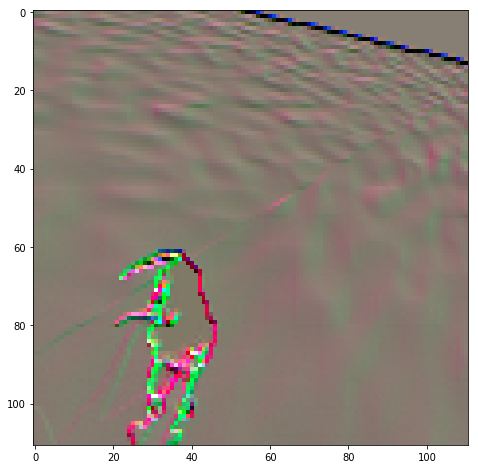

In [164]:
plt.imshow(deprocess_image(trya['layer_0'][:,:,18:21]))

## Old code

#### Compute features -original functions
to be removed

In [26]:

def cache_features(X, model,layerN=12):
    """
    """
    res  = sess.run( model.layers[layerN], feed_dict={model.image: X})
   # print("debug: shapes =", sal_shape, sc_shape, im_shape)
    return res

def cache_squeezed_features(X, model,squeezedlayerN=7):
    """
    """
    res  = sess.run( model.squeezed_layers[squeezedlayerN], feed_dict={model.image: X})
    return res

def cache_layers(X, model, layerN_list=[], sqeezed_layerN_list=[]):
    tensors = [ model.layers[i] for i in layerN_list ]    +   [ model.squeezed_layers[i] for i in sqeezed_layerN_list ]
    res  = sess.run( tensors, feed_dict={model.image: X})
    return res
    

In [46]:
trycache = cache_layers( myX[:10], model, [12], sqeezed_layerN_list=[7])

In [48]:
[ i.shape for i in trycache]

[(10, 13, 13, 512), (10, 13, 13, 64)]

In [46]:
#ftrs=cache_features(X,model) #13x13x512 layer
#sftrs=cache_sqeezed_features(X,model,7) #13x13x64 layer
#sftrs2x=cache_sqeezed_features(X,model,3) #27x27x32 layer
#sftrs4x=cache_sqeezed_features(X,model,1) #55x55x16 layer

In [91]:

def generate_XFeat_and_Y_in_memory ( inlist, Xraw, Xref,  model,  layerN_list=[], sqeezed_layerN_list=[] ):
    
    Ntot = len(layerN_list) + len(sqeezed_layerN_list)
    XFeat = [[]]*Ntot
    Y = []
    
    #process each record independently to minimize memory hiccups:
    assert( len(Xref) == len(Xraw)   and   len(Xref) == len(inlist) )
    for i in range(len(Xref)): 
        XX,YY = generate_XandY_for_single_elem(inlist[i],Xraw[i],Xref[i])
        XXFeat = cache_layers(XX, model, layerN_list, sqeezed_layerN_list )
        for i in range(Ntot):
            XFeat[i].extend(XXFeat[i])
        Y.extend(YY)
    return XFeat,Y


In [ ]:
trycache=generate_XFeat_and_Y_in_memory ( in_list[:2], my_Xraw[:2], my_Xref[:2],  model, [],[7])

### Create/read records

In [ ]:
generate_XFeat_and_Y_TFRecord(  in_list[:2], my_Xraw[:2], my_Xref[:2],  model, [],[7], debugN=2000 )

debug: opened writer YYY
debug: i= 0 , generated XX


In [19]:
! dir *tfrec

 Volume in drive C is TI10693600D
 Volume Serial Number is B401-2245

 Directory of C:\Users\Sergey\NeuralNetworks\fromSqueezeNet

10/22/2018  10:31 PM                 0 try1.tfrec
10/23/2018  07:25 PM            86,882 XandY.tfrec
               2 File(s)         86,882 bytes
               0 Dir(s)  506,684,440,576 bytes free


In [28]:
! dir *tfrec

 Volume in drive C is TI10693600D
 Volume Serial Number is B401-2245

 Directory of C:\Users\Sergey\NeuralNetworks\fromSqueezeNet

10/22/2018  10:31 PM                 0 try1.tfrec
10/27/2018  01:25 AM         8,688,200 XandY.tfrec
               2 File(s)      8,688,200 bytes
               0 Dir(s)  506,683,543,552 bytes free


In [139]:
! dir *tfrec

 Volume in drive C is TI10693600D
 Volume Serial Number is B401-2245

 Directory of C:\Users\Sergey\NeuralNetworks\fromSqueezeNet

10/22/2018  10:31 PM                 0 try1.tfrec
10/27/2018  02:23 AM        54,301,250 XandY.tfrec
10/27/2018  05:42 PM         6,308,698 XandY1.tfrec
               3 File(s)     60,609,948 bytes
               0 Dir(s)  503,097,765,888 bytes free


In [136]:
## unused - version to decode images converted to ByteStrings
#

def dataset_from_TFRecordOld ( layer_name_and_shape_list=[ ("squeezed_layer_8",13,13,64) ],   
                                filename="XandY.tfrec" ):  #, debugN=None ):
    
    Ykeys = ["angle_vert", "angle_horiz", "rooty", "rootx", "endy", "endx"]
    features1 = { name : tf.FixedLenFeature(shape=[], dtype=tf.string)  \
                for (name,W,H,D) in layer_name_and_shape_list }
    features2 = { k : tf.FixedLenFeature(shape=[1], dtype=tf.float32)  \
                for k in Ykeys }       
    features = { **features1, **features2 } # merge two dicts (python 3)
    #
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map( lambda x: tf.parse_single_example(x,features))
    return dataset


In [86]:
#sb
writer=tf.summary.FileWriter('.')
writer.add_graph(tf.get_default_graph())